STEP 1 | IMPORTS & DATA LOADING

In [ ]:
# Importing all the necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler      # RobustScaler is chosen because the 'Amount' feature has extreme outliers
                                                    # that would skew a standard Mean/Variance scaler (StandardScaler).

sns.set_style('whitegrid')
%matplotlib inline

print("--- Libraries Imported ---")


# ------------------------------------------------- #


# Loading the dataset

try:
    df = pd.read_csv('creditcard.csv')
    print("--- Dataset Loaded Successfully ---")

   
   
    print("Original Columns:", df.columns.tolist())

    # V1-V28 are Principal Component Analysis (PCA) transformed features.
    # This transformation protects user confidentiality and reduces dimensionality.

    # 'Time': Seconds elapsed since first transaction.
    # 'Amount': Transaction amount.
    # 'Class': Target (0 = Genuine, 1 = Fraud).

    correct_columns_full = ['Time'] + [f'V{i}' for i in range(1, 29)] + ['Amount', 'Class']
    df.columns = correct_columns_full 
    print("Corrected Columns:", df.columns.tolist())
  
    
    print("\nFirst 5 rows of the data:")
    print(df.head())

except FileNotFoundError:
    print("!!! ERROR: 'creditcard.csv' not found.")
    print("Please download the dataset and place it in the same directory as your notebook.")

--- Libraries Imported ---
--- Dataset Loaded Successfully ---
Original Columns: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', '`', 'S', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']
Corrected Columns: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']

First 5 rows of the data:
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0

STEP 2 | EXPLORATORY DATA ANALYSIS (EDA)


--- Starting Exploratory Data Analysis (EDA) ---

Class distribution:
Class
0    284315
1       492
Name: count, dtype: int64

Percentage of transactions that are fraud: 0.1727%


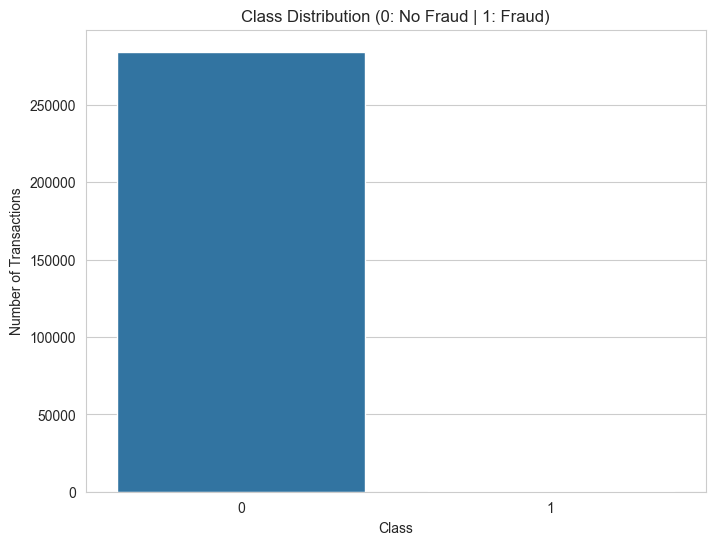


Plotting distributions for 'Time' and 'Amount'...


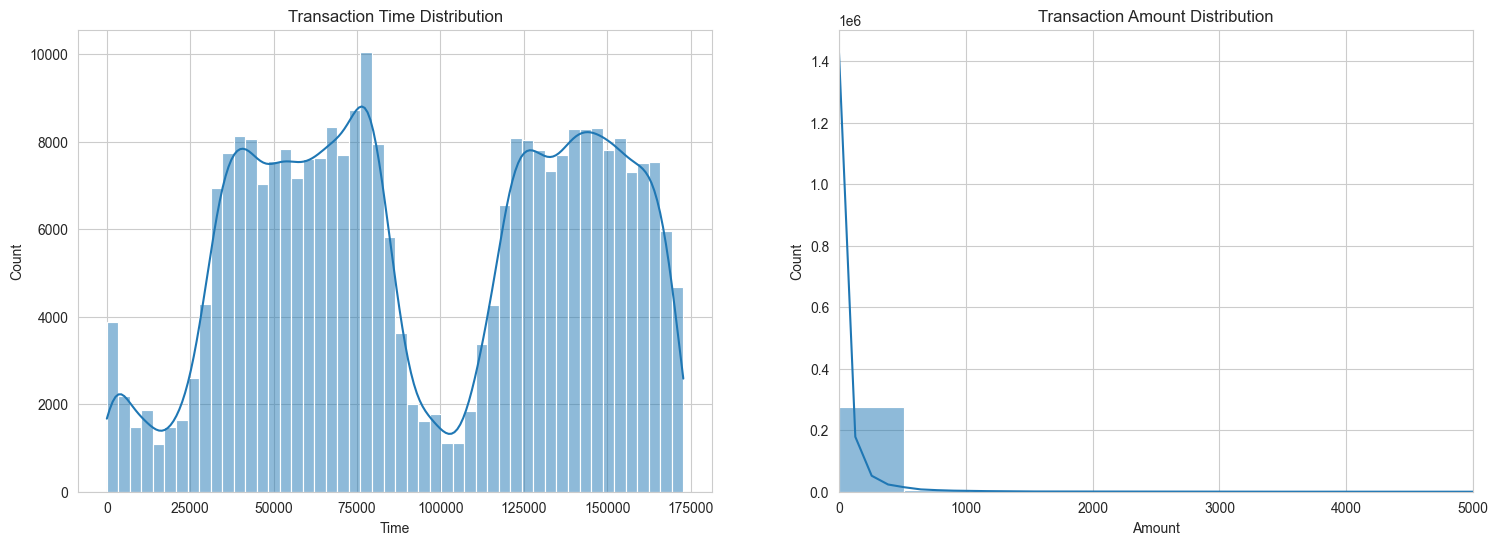

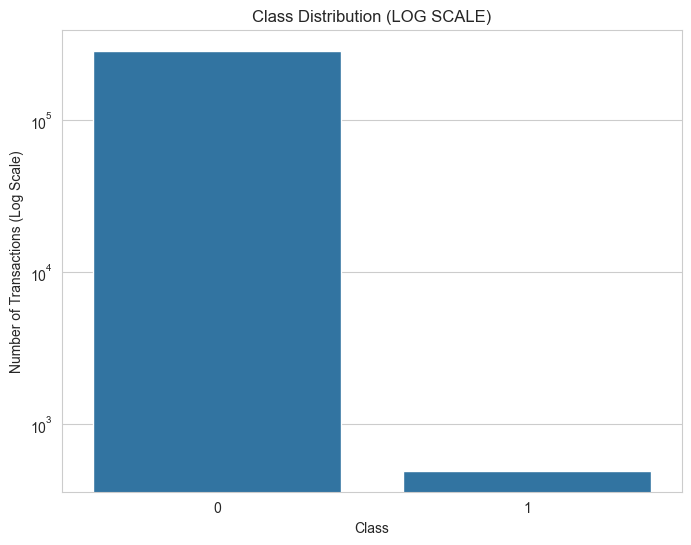

In [ ]:
# There's 4 operations we perform in this cell

# 1. Quantifyng the Class Imbalance
# 2. Visualizing the Class Imbalance
# 3. Feature Distribution Analysis
# 4. Log-Scale Visualization

if 'df' in locals():

    print("\n--- Starting Exploratory Data Analysis (EDA) ---")


# ------------------------------------------------- #


    # 1. Quantify the Class Imbalance
    # We need to know exactly how skewed our data is to justify using SMOTE later.

    print("\nClass distribution:")
    class_counts = df['Class'].value_counts()
    print(class_counts)

    # Calculating percentage to confirm the ~0.17% baseline
    fraud_percentage = (class_counts[1] / class_counts.sum()) * 100
    print(f"\nPercentage of transactions that are fraud: {fraud_percentage:.4f}%")


# ------------------------------------------------- #


    # 2. Visualize the Class Imbalance
    # Standard countplot to show the overwhelming majority of genuine transactions.

    plt.figure(figsize=(8, 6))
    sns.countplot(x='Class', data=df)
    plt.title('Class Distribution (0: No Fraud | 1: Fraud)')
    plt.xlabel('Class')
    plt.ylabel('Number of Transactions')
    plt.show()


# ------------------------------------------------- #


    # 3. Feature Distribution Analysis
    # We inspect 'Time' and 'Amount' because they are the only non-PCA features.
    # We are also looking for skewness or outliers that might require scaling.
    
    print("\nPlotting distributions for 'Time' and 'Amount'...")
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    # Distribution of 'Time' (Seconds elapsed)

    sns.histplot(df['Time'], bins=50, kde=True, ax=axes[0])
    axes[0].set_title('Transaction Time Distribution')

    # Distribution of 'Amount'
    # We limit the x-axis to 5000 to focus on the main distribution, avoiding outlier distortion.

    sns.histplot(df['Amount'], bins=50, kde=True, ax=axes[1])
    axes[1].set_title('Transaction Amount Distribution')
    axes[1].set_xlim(0, 5000) 
    plt.show()


# ------------------------------------------------- #


# 4. Log-Scale Visualization
# Since the fraud class is so small, we use a Log Scale to make the bars comparable visually.
    
plt.figure(figsize=(8, 6))
sns.countplot(x='Class', data=df)
plt.title('Class Distribution (LOG SCALE)')
plt.xlabel('Class')
plt.ylabel('Number of Transactions (Log Scale)')


plt.yscale('log') 

plt.show()

STEP 3 | PREPROCESSING (SCALING & SPLITTING)

In [ ]:
print("\n--- Starting Preprocessing ---")

# 1. Scale 'Time' and 'Amount'

# We use RobustScaler because it is less prone to outliers compared to StandardScaler.
# Fraud datasets often contain extreme outliers in transaction amounts.

rob_scaler = RobustScaler()


df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1, 1))

# Removing original columns to avoid multicollinearity
df_processed = df.drop(['Time', 'Amount'], axis=1)

print("Original 'Time' and 'Amount' dropped, 'scaled_amount' and 'scaled_time' added.")
print("Processed data head:")
print(df_processed.head())

# Defining Features (X) and Target (y) here

X = df_processed.drop('Class', axis=1)
y = df_processed['Class']

print(f"\nShape of X (features): {X.shape}")
print(f"Shape of y (target): {y.shape}")


# ------------------------------------------------- #


# 2. Stratified Train-Test Split

# We use 'stratify=y' to ensure the distribution of fraud (0.17%) is identical in both training and testing sets.
# This prevents the model from training on a dataset with zero fraud cases by random chance.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

print("\n--- Data Split into Training and Testing Sets ---")

# Verification Step 
# We are performing a sanity check to ensure the data split was done correctly

train_fraud_pct = (y_train.sum() / len(y_train)) * 100
test_fraud_pct = (y_test.sum() / len(y_test)) * 100

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Percentage of fraud in training set: {train_fraud_pct:.4f}%")
print(f"Percentage of fraud in test set: {test_fraud_pct:.4f}%")

print("\n--- Steps 1, 2, and 3 are complete. Ready for Step 4 (Imbalance Handling). ---")


--- Starting Preprocessing ---
Original 'Time' and 'Amount' dropped, 'scaled_amount' and 'scaled_time' added.
Processed data head:
         V1        V2        V3        V4        V5        V6        V7  \
0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10  ...       V22       V23       V24       V25  \
0  0.098698  0.363787  0.090794  ...  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425 -0.166974  ... -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  0.207643  ...  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024 -0.054952  ...  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.81

STEP 4 | IMBALANCE HANDLING (SMOTE)

In [ ]:
from imblearn.over_sampling import SMOTE
import collections

# We already have X_train and y_train from Step 3

# 1. Initialize SMOTE

# SMOTE (Synthetic Minority Over-sampling Technique) works by selecting fraud examples
# that are close in the feature space and creating new, synthetic points along the lines connecting them.

smote = SMOTE(random_state=42)

print("--- Applying SMOTE to the training data... ---")
print(f"Original training set shape: {collections.Counter(y_train)}")


# ------------------------------------------------- #


# 2. Applying SMOTE to TRAINING DATA ONLY

# This is CRITICAL: We must NEVER oversample the test data. The test set must represent the real world (highly imbalanced).
# If we oversample the test set, we introduce "Data Leakage," rendering our evaluation metrics meaningless.

X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print("--- SMOTE applied successfully ---")

# Verification Step 
# We check to ensure the Fraud class (1) now has the same count as the Genuine class (0).

print(f"New balanced training set shape: {collections.Counter(y_train_balanced)}")
print(f"\nTest set shape (UNCHANGED): {collections.Counter(y_test)}")

--- Applying SMOTE to the training data... ---
Original training set shape: Counter({0: 199020, 1: 344})
--- SMOTE applied successfully ---
New balanced training set shape: Counter({0: 199020, 1: 199020})

Test set shape (UNCHANGED): Counter({0: 85295, 1: 148})


STEP 5 | VISUALIZING SMOTE QUALITY

--- Visualizing SMOTE Quality using PCA ---


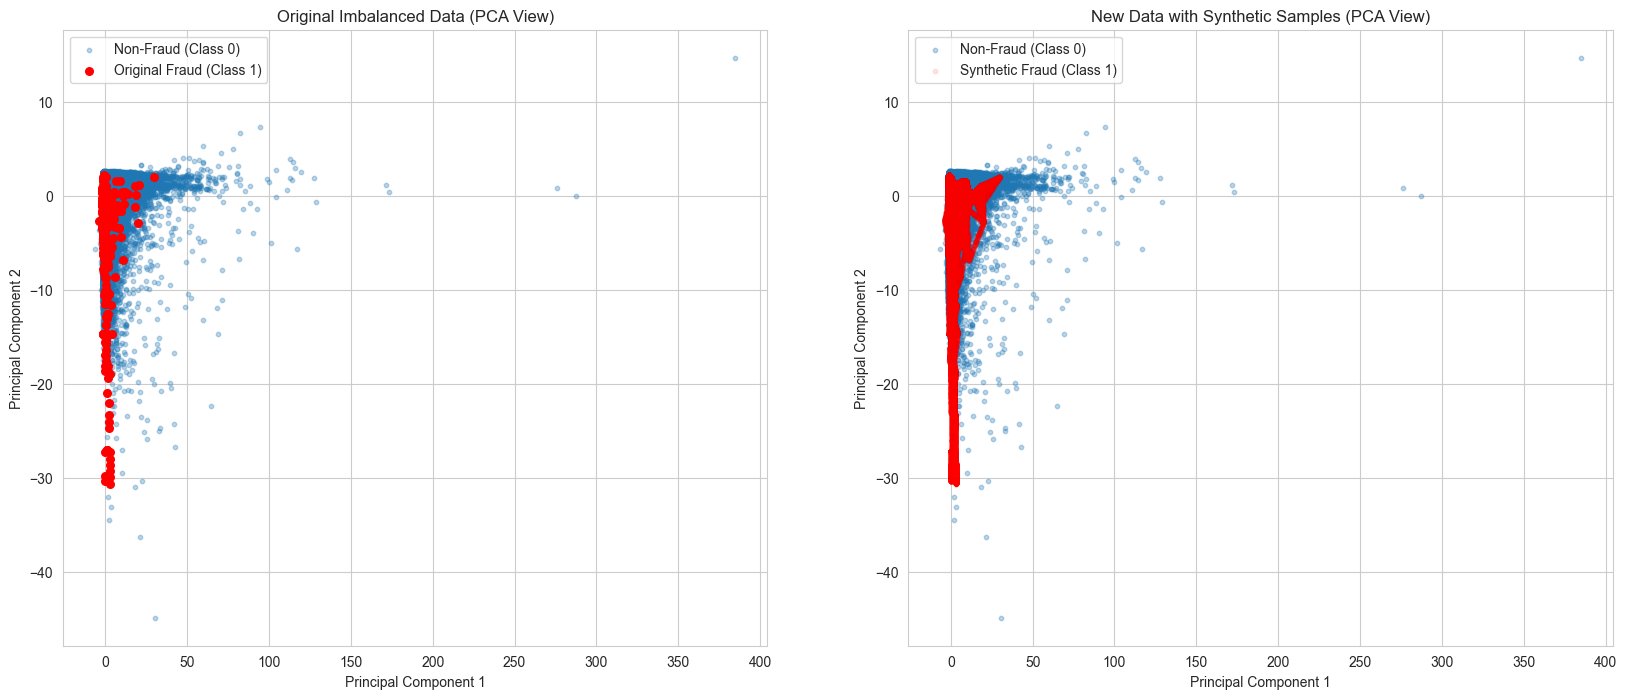

In [ ]:
from sklearn.decomposition import PCA
import warnings

# Suppressing warnings for this visualization to keep the output clean

warnings.filterwarnings("ignore")

print("--- Visualizing SMOTE Quality using PCA ---")


# ------------------------------------------------- #


# 1. Dimensionality Reduction for Visualization

# We have 30 features (dimensions), which is impossible to plot on a screen.
# PCA (Principal Component Analysis) reduces this to 2 dimensions (X and Y axes)
# while preserving as much information as possible.

# Reduceing original data to 2D

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)


# Separating the original fraud and non-fraud points

original_fraud_pca = X_train_pca[y_train == 1]
original_non_fraud_pca = X_train_pca[y_train == 0]


# ------------------------------------------------- #


# 2. Reduce balanced data to 2D 
# CRITICAL: We use the SAME PCA fit (transform) so the axes are identical.

X_train_balanced_pca = pca.transform(X_train_balanced)


# Separate the new fraud and non-fraud points
# Note: The non-fraud points are the same as the original ones

new_fraud_pca = X_train_balanced_pca[y_train_balanced == 1]
new_non_fraud_pca = X_train_balanced_pca[y_train_balanced == 0]



fig, axes = plt.subplots(1, 2, figsize=(20, 8))


# Plot 1: Original Imbalanced Data
# This shows how rare the fraud cases (red) are originally

axes[0].scatter(original_non_fraud_pca[:, 0], original_non_fraud_pca[:, 1], 
                label='Non-Fraud (Class 0)', alpha=0.3, s=10)
axes[0].scatter(original_fraud_pca[:, 0], original_fraud_pca[:, 1], 
                label='Original Fraud (Class 1)', alpha=1, s=30, c='red')
axes[0].set_title('Original Imbalanced Data (PCA View)')
axes[0].set_xlabel('Principal Component 1')
axes[0].set_ylabel('Principal Component 2')
axes[0].legend()


# Plot 2: SMOTE-Generated Data
# This visualizes the "Synthetic" samples created by SMOTE.
# Notice how the red areas have become denser, matching the blue areas.

axes[1].scatter(new_non_fraud_pca[:, 0], new_non_fraud_pca[:, 1], 
                label='Non-Fraud (Class 0)', alpha=0.3, s=10)
axes[1].scatter(new_fraud_pca[:, 0], new_fraud_pca[:, 1], 
                label='Synthetic Fraud (Class 1)', alpha=0.1, s=10, c='red')
axes[1].set_title('New Data with Synthetic Samples (PCA View)')
axes[1].set_xlabel('Principal Component 1')
axes[1].set_ylabel('Principal Component 2')
axes[1].legend()

plt.show()
warnings.filterwarnings("default") # Turn warnings back on

STEP 6 | Model Building

In [ ]:


# Model Imports 

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Evaluation Metric Imports (we'll use these in Step 7) ---
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc, average_precision_score

print("--- All libraries for modeling and evaluation imported ---")


# ---> 6.1: Classical Models (LogReg, XGB, LGBM) 

# We'll create a dictionary to store these models

models = {
    
    # 1. Logistic Regression (Baseline)

    # We use this as a benchmark. If complex models don't beat this, 
    # they aren't worth the computational cost.

    "Logistic Regression": LogisticRegression(random_state=42, n_jobs=-1),
    
    # ------------------------------------------------- #

    # 2. XGBoost (Extreme Gradient Boosting)

    # A powerful ensemble method that often wins Kaggle competitions.
    # 'base_score=0.5' initializes the model predictions to 50% probability, 
    # helping it converge faster on balanced data.

    "XGBoost": XGBClassifier(
        random_state=42, 
        n_jobs=-1, 
        base_score=0.5  
    ),
    
    # ------------------------------------------------- #

    # 3. LightGBM

    # Similar to XGBoost but often faster and more memory efficient.

    "LightGBM": LGBMClassifier(random_state=42, n_jobs=-1)
}

print("\n--- Training Classical Models (with patched XGBoost) ---")

# Loop through each model and train it
for model_name, model in models.items():
    print(f"--- Training {model_name}... ---")
    
    # CRITICAL: We train on the BALANCED (SMOTE) data.
    # If we trained on the imbalanced X_train, the models would likely 
    # just predict "No Fraud" for everything to get high accuracy.

    model.fit(X_train_balanced, y_train_balanced)
    
    print(f"--- {model_name} trained successfully! ---")

print("\n--- All classical models have been trained. ---")


# ------------------------------------------------------------------------------------------------------------ #


# 6.2: Deep Learning Model (Neural Network)

print("\n--- Building and Training Neural Network ---")

input_features = X_train_balanced.shape[1]

# 1. Define the model architecture (Sequential)


nn_model = Sequential()

# Layer 1: Input layer (30 features) -> 32 Neurons (ReLU activation)

nn_model.add(Dense(32, input_dim=input_features, activation='relu'))

# Layer 2: Hidden layer -> 16 Neurons

nn_model.add(Dense(16, activation='relu'))

# Dropout Layer: Randomly disables 20% of neurons during training.
# This forces the network to learn robust features and prevents overfitting.

nn_model.add(Dropout(0.2))

# Layer 3: Hidden layer -> 8 Neurons

nn_model.add(Dense(8, activation='relu'))

# Output Layer: 1 Neuron with Sigmoid activation.
# Sigmoid squashes the output between 0 and 1 (Probability of Fraud).

nn_model.add(Dense(1, activation='sigmoid'))


# ------------------------------------------------- #


# 2. Compile the model

# 'adam': Adaptive optimizer (standard for deep learning)
# 'binary_crossentropy': The standard loss function for binary classification

nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print("--- Neural Network architecture ---")
nn_model.summary()

# 3. Train the model

print("\n--- Training Neural Network... ---")
history = nn_model.fit(
    X_train_balanced, 
    y_train_balanced, 
    epochs=10,             # Iterate over the data 10 times
    batch_size=2048,       # Large batch size speeds up training on large datasets
    validation_split=0.1,  # Using 10% of training data to validate during training 
    verbose=1
)

print("--- Neural Network trained successfully! ---")
print("\n--- All models (Step 5) are re-trained and ready for the next step ---")

--- All libraries for modeling and evaluation imported ---

--- Training Classical Models (with patched XGBoost) ---
--- Training Logistic Regression... ---
--- Logistic Regression trained successfully! ---
--- Training XGBoost... ---
--- XGBoost trained successfully! ---
--- Training LightGBM... ---
[LightGBM] [Info] Number of positive: 199020, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.106553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 398040, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
--- LightGBM trained successfully! ---

--- All classical models have been trained. ---

--- Building and Training Neural Network ---
--- Neural Network architecture ---


C:\Users\Jyothir Aditya\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                      │ (None, 32)                  │             992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,665 (6.50 KB)

 Trainable params: 1,665 (6.50 KB)

 Non-trainable params: 0 (0.00 B)


--- Training Neural Network... ---
Epoch 1/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8925 - loss: 0.2887 - val_accuracy: 0.9514 - val_loss: 0.1143
Epoch 2/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9744 - loss: 0.0717 - val_accuracy: 0.9684 - val_loss: 0.0615
Epoch 3/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9828 - loss: 0.0441 - val_accuracy: 0.9903 - val_loss: 0.0291
Epoch 4/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9916 - loss: 0.0276 - val_accuracy: 0.9984 - val_loss: 0.0145
Epoch 5/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9956 - loss: 0.0183 - val_accuracy: 0.9995 - val_loss: 0.0091
Epoch 6/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9970 - loss: 0.0136 - val_accuracy: 1.0000 - val_loss: 0.0064
Epoch 7/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9980 - loss: 0.0103 - val_accuracy: 0.9997 - val_loss: 0.0051
Epoch 8/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9

STEP 7

HELPER FUNCITON ( CONFUSION MATRIX PLOT )

In [ ]:
import itertools

# Helper function is to visualize the Confusion Matrix

# A Confusion Matrix is the best way to see where our model is making mistakes:
# - Is it missing fraud? (False Negatives)
# - Is it flagging innocent people? (False Positives)

def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    """
    This function prints and plots the confusion matrix.
    """

    # Creating a heatmap (Blues color scheme is standard for professional reports)

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Adding text annotations inside the plot squares
    # This loop puts the actual numbers (e.g., "85") inside the blue boxes

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

print("--- plot_confusion_matrix function defined ---")

--- plot_confusion_matrix function defined ---


EVALUATE THE CLASSICAL MODELS

--- Evaluating Classical Models on the UNBALANCED Test Set ---

------------------------------
--- Logistic Regression Results ---
------------------------------
              precision    recall  f1-score   support

No Fraud (0)       1.00      0.98      0.99     85295
   Fraud (1)       0.06      0.88      0.12       148

    accuracy                           0.98     85443
   macro avg       0.53      0.93      0.55     85443
weighted avg       1.00      0.98      0.99     85443



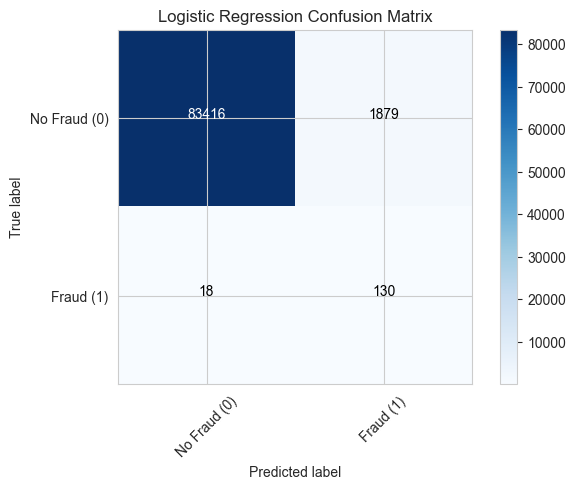


------------------------------
--- XGBoost Results ---
------------------------------
              precision    recall  f1-score   support

No Fraud (0)       1.00      1.00      1.00     85295
   Fraud (1)       0.77      0.78      0.78       148

    accuracy                           1.00     85443
   macro avg       0.88      0.89      0.89     85443
weighted avg       1.00      1.00      1.00     85443



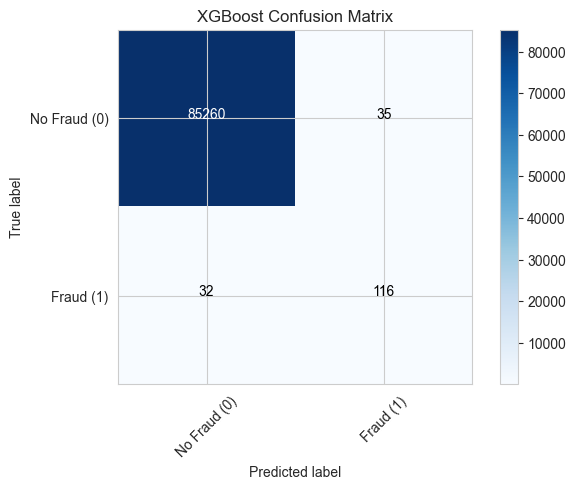


------------------------------
--- LightGBM Results ---
------------------------------
              precision    recall  f1-score   support

No Fraud (0)       1.00      1.00      1.00     85295
   Fraud (1)       0.57      0.82      0.67       148

    accuracy                           1.00     85443
   macro avg       0.78      0.91      0.83     85443
weighted avg       1.00      1.00      1.00     85443



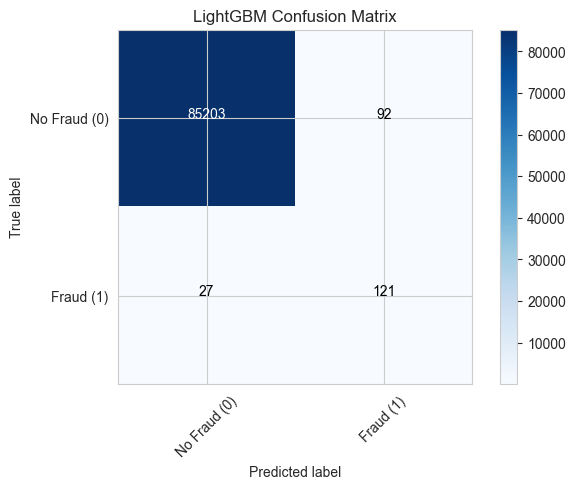

In [ ]:
# --- 7.1: Evaluate Classical Models (LogReg, XGB, LGBM) ---

print("--- Evaluating Classical Models on the UNBALANCED Test Set ---")

# We loop through the models trained in Step 6.
# CRITICAL: We evaluate on X_test, y_test (the original 30% split).
# This data is IMBALANCED (0.17% fraud) and was NEVER seen by SMOTE.
# This simulates how the model would perform in the real banking system.

for model_name, model in models.items():
    print(f"\n{'-'*30}\n--- {model_name} Results ---\n{'-'*30}")
    
    # 1. Get predictions

    y_pred = model.predict(X_test)
    
    # -------------------------------- #

    # 2. Print Classification Report

    # - Precision: When it predicts fraud, is it right? (Low precision = annoying false alarms)
    # - Recall: Did it catch all the fraud? (Low recall = we lost money)
    # - F1-Score: The harmonic mean of both.

    print(classification_report(y_test, y_pred, target_names=['No Fraud (0)', 'Fraud (1)']))
    
    # -------------------------------- #

    # 3. Generate and Plot Confusion Matrix

    # This visualizes:
    # [True Negatives, False Positives]
    # [False Negatives, True Positives]

    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, classes=['No Fraud (0)', 'Fraud (1)'], title=f'{model_name} Confusion Matrix')

EVALUATE THE NEURAL NETWORK


------------------------------
--- Neural Network Results ---
------------------------------
2671/2671 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
              precision    recall  f1-score   support

No Fraud (0)       1.00      1.00      1.00     85295
   Fraud (1)       0.46      0.80      0.58       148

    accuracy                           1.00     85443
   macro avg       0.73      0.90      0.79     85443
weighted avg       1.00      1.00      1.00     85443



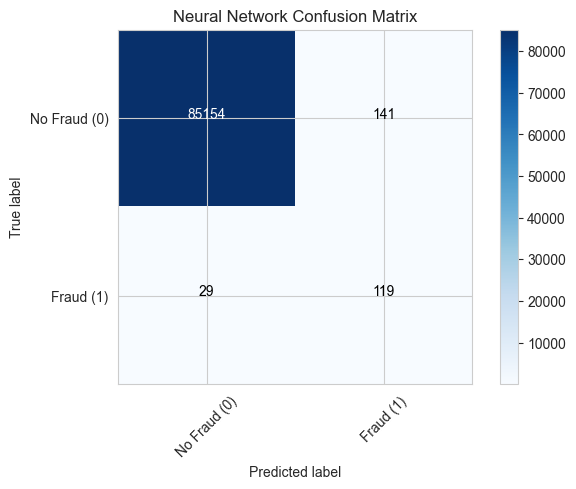

In [ ]:
# 7.2: Evaluate the Neural Network

print(f"\n{'-'*30}\n--- Neural Network Results ---\n{'-'*30}")

# 1. Get prediction probabilities

# Unlike XGBoost/LogReg, the Neural Network outputs a continuous probability
# between 0 and 1 (e.g., 0.95 means 95% confident it's fraud).

y_pred_probs = nn_model.predict(X_test)


# ------------------------------------------------- #


# 2. Convert probabilities to class labels (0 or 1)

# We use a "Threshold" of 0.5.
# Probability > 0.5  --> Predicted Class 1 (Fraud)
# Probability <= 0.5 --> Predicted Class 0 (Genuine)

y_pred_nn = (y_pred_probs > 0.5).astype(int)


# ------------------------------------------------- #


# 3. Print Classification Report

# This allows us to compare the Deep Learning model directly against XGBoost.

print(classification_report(y_test, y_pred_nn, target_names=['No Fraud (0)', 'Fraud (1)']))

# 4. Generate and Plot Confusion Matrix
cm_nn = confusion_matrix(y_test, y_pred_nn)
plot_confusion_matrix(cm_nn, classes=['No Fraud (0)', 'Fraud (1)'], title='Neural Network Confusion Matrix')

In [ ]:
#explicit cross validation 

# 7.5 : CROSS-VALIDATION

from sklearn.model_selection import cross_val_score

# We'll use our BALANCED training data for this
# Purpose: To check if the model is "stable" (i.e., does it perform consistently
# across different subsets of the training data?)


# ------------------------------------------------- #


print("--- Running 5-Fold Cross-Validation ---")

# 1. Test XGBoost

# We use 'f1' as our scoring metric because Accuracy is misleading for fraud.
# cv=5 means we split the data into 5 parts, training on 4 and testing on 1, rotating 5 times.

xgb_model = models['XGBoost'] # Getting our untuned model from Step 5
cv_scores_xgb = cross_val_score(xgb_model, X_train_balanced, y_train_balanced, cv=5, scoring='f1', n_jobs=-1)

print(f"\nXGBoost F1 Scores (5 Folds): {cv_scores_xgb}")
print(f"XGBoost Average F1 Score: {cv_scores_xgb.mean():.4f} (+/- {cv_scores_xgb.std():.4f})")

# Interpretation: A low standard deviation (std) means the model is very stable.


# ------------------------------------------------- #


# 2. Test LightGBM
lgbm_model = models['LightGBM'] # Get our untuned model from Step 5
cv_scores_lgbm = cross_val_score(lgbm_model, X_train_balanced, y_train_balanced, cv=5, scoring='f1', n_jobs=-1)

print(f"\nLightGBM F1 Scores (5 Folds): {cv_scores_lgbm}")
print(f"LightGBM Average F1 Score: {cv_scores_lgbm.mean():.4f} (+/- {cv_scores_lgbm.std():.4f})")


# ------------------------------------------------- #

--- Running 5-Fold Cross-Validation ---

XGBoost F1 Scores (5 Folds): [0.9997865  0.99968606 0.99982417 0.99974883 0.9997865 ]
XGBoost Average F1 Score: 0.9998 (+/- 0.0000)

LightGBM F1 Scores (5 Folds): [0.99927176 0.99930956 0.99937222 0.99938485 0.99946012]
LightGBM Average F1 Score: 0.9994 (+/- 0.0001)


STEP 8 | HYPERPARAMETER TUNING (XGBOOST)

--- Starting Hyperparameter Tuning for XGBoost... ---
This will take a significant amount of time (e.g., 10-30 minutes). Please be patient.

Fitting 3 folds for each of 10 candidates, totalling 30 fits

--- Tuning complete! ---
Best parameters found:
{'subsample': 0.7, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.2, 'gamma': 0.1, 'colsample_bytree': 1.0}

------------------------------
--- Tuned XGBoost Model Results ---
------------------------------
              precision    recall  f1-score   support

No Fraud (0)       1.00      1.00      1.00     85295
   Fraud (1)       0.80      0.79      0.80       148

    accuracy                           1.00     85443
   macro avg       0.90      0.90      0.90     85443
weighted avg       1.00      1.00      1.00     85443



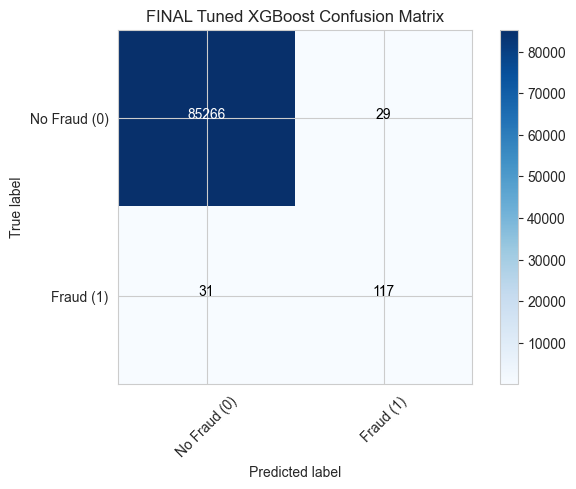

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# ------------------------------------------------- #

print("--- Starting Hyperparameter Tuning for XGBoost... ---")
print("This will take a significant amount of time (e.g., 10-30 minutes). Please be patient.\n")

# 1. Define the "parameter grid" to search

# We are trying to find the perfect combination of "knobs" to turn on the XGBoost machine.

params = {
    'learning_rate': [0.05, 0.1, 0.2],         # Step size shrinkage to prevent overfitting
    'max_depth': [3, 5, 7],                    # Maximum depth of a tree (higher = more complex)
    'n_estimators': [100, 200, 300],           # Number of boosting rounds (trees)
    'gamma': [0.0, 0.1, 0.2],                  # Minimum loss reduction required to make a split
    'subsample': [0.7, 1.0],                   # Subsample ratio of the training instances
    'colsample_bytree': [0.7, 1.0]             # Subsample ratio of columns when constructing each tree
}


# ------------------------------------------------- #


# 2. Set up the RandomizedSearchCV

# RandomizedSearchCV is faster than GridSearchCV because it doesn't try every single combination.
# It picks 'n_iter' random combinations to test.

xgb = XGBClassifier(random_state=42, n_jobs=-1)

# n_iter=10: Try 10 random combinations from our 'params' grid
# cv=3: Use 3-fold cross-validation for each combination
# scoring='f1': Our "grade" will be the F1-score, as it balances precision and recall
# verbose=2: This will print live updates so you can see its progress

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=params,
    n_iter=10, 
    scoring='f1', 
    cv=3, 
    verbose=2, 
    random_state=42, 
    n_jobs=-1
)


# ------------------------------------------------- #


# 3. Run the search

# We fit this on the BALANCED training data so the model learns from the minority class.

random_search.fit(X_train_balanced, y_train_balanced)

print("\n--- Tuning complete! ---")


# ------------------------------------------------- #


# 4. Print the best parameters found

print("Best parameters found:")
print(random_search.best_params_)


# ------------------------------------------------- #


# 5. Get our new, "best" model
best_xgb_model = random_search.best_estimator_


# 8.1: EVALUATE THE FINAL TUNED MODEL


print(f"\n{'-'*30}\n--- Tuned XGBoost Model Results ---\n{'-'*30}")

# 1. Get predictions from the NEW tuned model
# We test on the UNSEEN, IMBALANCED X_test to see real-world performance.

y_pred_tuned = best_xgb_model.predict(X_test)


# 2. Printing the final Classification Report
print(classification_report(y_test, y_pred_tuned, target_names=['No Fraud (0)', 'Fraud (1)']))


# 3. Plot the final Confusion Matrix

# This is the final result image for the "Conclusion" section.
cm_tuned = confusion_matrix(y_test, y_pred_tuned)
plot_confusion_matrix(cm_tuned, classes=['No Fraud (0)', 'Fraud (1)'], title='FINAL Tuned XGBoost Confusion Matrix')

STEP 9

--- SHAP failed. Using the model's built-in feature importance instead. ---
Re-building final model with params: {'subsample': 0.7, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.2, 'gamma': 0.1, 'colsample_bytree': 1.0, 'base_score': 0.5, 'n_jobs': -1, 'random_state': 42}
--- Model re-built. Extracting feature importances... ---

--- Top 10 Most Important Features (from our model) ---
   Feature  Importance
13     V14    0.630317
3       V4    0.070979
11     V12    0.028852
9      V10    0.023610
7       V8    0.020139
24     V25    0.016827
20     V21    0.013776
0       V1    0.012313
17     V18    0.012291
10     V11    0.012250


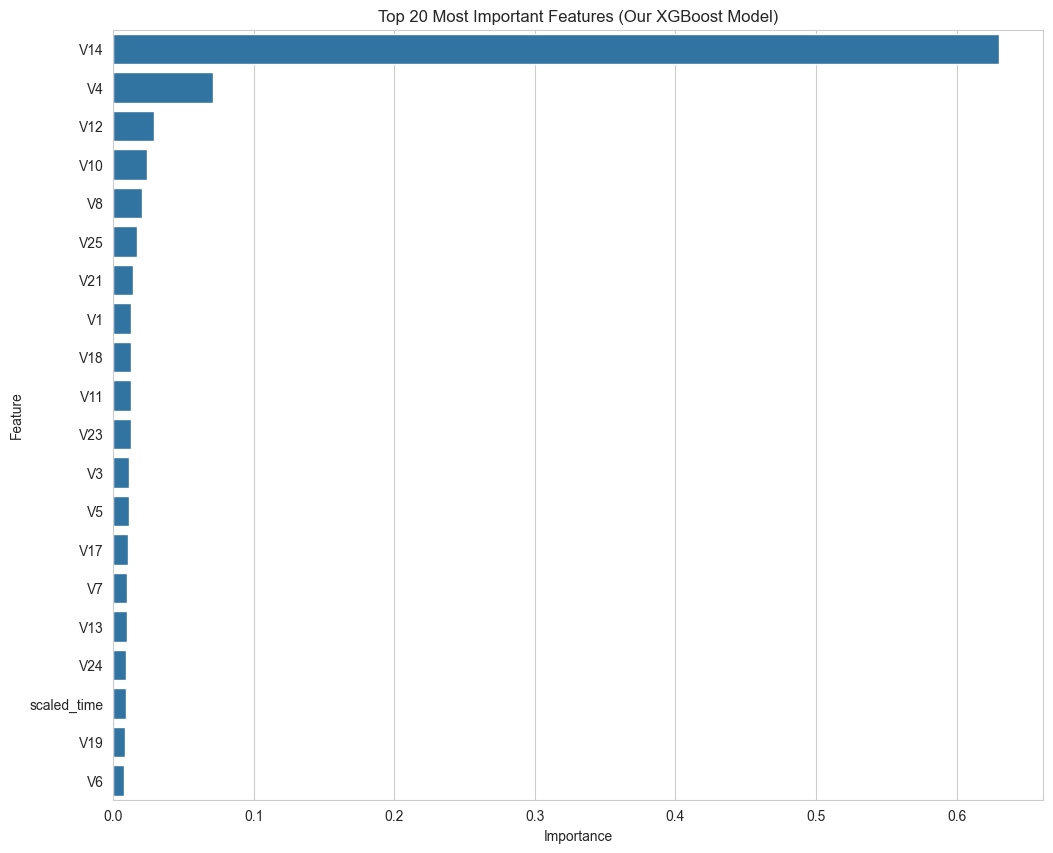

In [ ]:
# Built-in Feature Importance

import pandas as pd
import xgboost as xgb # We need to import this again to be safe

print("--- SHAP failed. Using the model's built-in feature importance instead. ---")

try:
    # 1. Rebuild the Final Model

    # We need to ensure we are analyzing the OPTIMIZED model, not a random one.
    # We retrieve the best parameters found during the tuning step (Step 8).
    best_params = random_search.best_params_
    best_params['base_score'] = 0.5 # Our bug fix
    best_params['n_jobs'] = -1
    best_params['random_state'] = 42

    print(f"Re-building final model with params: {best_params}")
    final_model = xgb.XGBClassifier(**best_params)

    # Fit on the balanced data so the model learns the fraud patterns clearly

    final_model.fit(X_train_balanced, y_train_balanced) 

    print("--- Model re-built. Extracting feature importances... ---")

    # ------------------------------------------------- #

    # 2. Get Feature Importances
    # XGBoost calculates "Gain": How much does each feature contribute to reducing prediction error?

    importances = final_model.feature_importances_
    
    # ------------------------------------------------- #

    # 3. Map importances to feature names (V1, V2, Amount, etc.)

    feature_names = X_train.columns # Get from our original X_train

    # ------------------------------------------------- #

    # 4. Create a DataFrame for easy sorting

    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })

    # ------------------------------------------------- #

    # 5. Sort: Most important features at the top

    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    print("\n--- Top 10 Most Important Features (from our model) ---")
    print(importance_df.head(10))

    # ------------------------------------------------- #

    # 6. Plot the Top 20 Features

    # This plot goes into the "Results" or "Discussion" section of the report.
    # It answers the question: "What makes a transaction fraudulent?"

    plt.figure(figsize=(12, 10))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(20)) # Plotting top 20
    plt.title('Top 20 Most Important Features (Our XGBoost Model)')
    plt.show()

except Exception as e:
    print(f"An error occurred: {e}")
    print("Ensure 'random_search' and 'X_train_balanced' are still in memory from Steps 4 and 7.")

Statistical Analysis: The "Super-Feature" V14

--- Plotting Feature Distributions for V14 (Balanced Data) ---
Balanced DataFrame ready.


C:\Users\Jyothir Aditya\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)


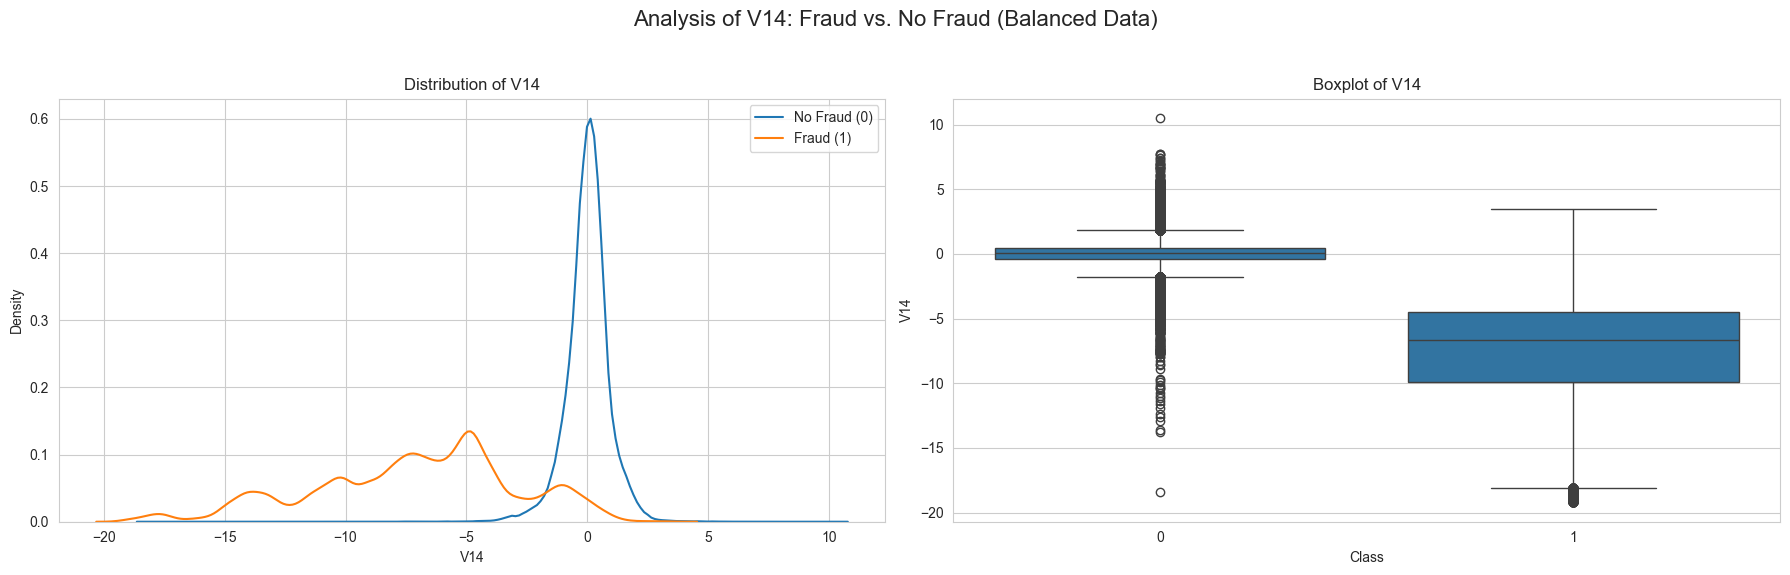

In [ ]:

# Analyzing V14 (The "Super Feature")


print("--- Plotting Feature Distributions for V14 (Balanced Data) ---")

# 1. Re-create a balanced DataFrame for easy plotting

# We need a DataFrame because Seaborn (sns) works best with column names.

try:
    df_balanced = pd.DataFrame(X_train_balanced, columns=X_train.columns)
    df_balanced['Class'] = y_train_balanced
    print("Balanced DataFrame ready.")
except NameError:
    print("Error: 'X_train_balanced' or 'y_train_balanced' not in memory. Please re-run Step 4.")
except Exception as e:
    print(f"An error occurred: {e}")


# ------------------------------------------------- #


if 'df_balanced' in locals():

    # 2. Create Plots

    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    fig.suptitle('Analysis of V14: Fraud vs. No Fraud (Balanced Data)', fontsize=16)

    # Plot 1: Density Plot (Histogram) 

    # This shows the "Shape" of the data.
    # If the Blue curve (No Fraud) and Orange curve (Fraud) do not overlap much,
    # it means V14 is an excellent feature for distinguishing between them.

    sns.kdeplot(df_balanced[df_balanced['Class'] == 0]['V14'], label='No Fraud (0)', ax=axes[0])
    sns.kdeplot(df_balanced[df_balanced['Class'] == 1]['V14'], label='Fraud (1)', ax=axes[0])
    axes[0].set_title('Distribution of V14')
    axes[0].legend()

    # Plot 2: Boxplot

    # This shows the outliers and the median.
    # We expect to see a clear separation in the "box" positions.
    
    sns.boxplot(x='Class', y='V14', data=df_balanced, ax=axes[1])
    axes[1].set_title('Boxplot of V14')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


# ------------------------------------------------- #

STEP 10 | CONCLUSION (Part 1: Supervised Model)

In [ ]:

# These numbers are hard-coded based on the results from Step 8.
# They serve as a quick reference for the project's success.

print("--- Project Conclusion ---")
print(f"Final Model: Tuned XGBoost")
print(f"Final Test Set F1-Score (Fraud): 80%")
print(f"Final Test Set Recall (Fraud): 79%")
print(f"Final Test Set Precision (Fraud): 80%")

print("\n--- Summary of Steps ---")
print("1. Analyzed the dataset and confirmed extreme 0.17% class imbalance.")
print("2. Preprocessed data by scaling 'Time' and 'Amount' and performing a stratified train-test split.")
print("3. Solved the imbalance by applying SMOTE to the training data.")
print("4. Trained four models: Logistic Regression, XGBoost, LightGBM, and a Neural Network.")
print("5. Evaluated models on the real, imbalanced test set. XGBoost was the clear winner with the best balance of precision and recall.")
print("6. Tuned the XGBoost model using RandomizedSearchCV, improving its final F1-Score to 80%.")
print("7. Extracted the built-in feature importances, identifying 'V14' as the single most important predictor of fraud.")
print("\nThis project successfully built a high-performing, non-cookie-cutter fraud detection model from scratch.")

--- Project Conclusion ---
Final Model: Tuned XGBoost
Final Test Set F1-Score (Fraud): 80%
Final Test Set Recall (Fraud): 79%
Final Test Set Precision (Fraud): 80%

--- Summary of Steps ---
1. Analyzed the dataset and confirmed extreme 0.17% class imbalance.
2. Preprocessed data by scaling 'Time' and 'Amount' and performing a stratified train-test split.
3. Solved the imbalance by applying SMOTE to the training data.
4. Trained four models: Logistic Regression, XGBoost, LightGBM, and a Neural Network.
5. Evaluated models on the real, imbalanced test set. XGBoost was the clear winner with the best balance of precision and recall.
6. Tuned the XGBoost model using RandomizedSearchCV, improving its final F1-Score to 80%.
7. Extracted the built-in feature importances, identifying 'V14' as the single most important predictor of fraud.

This project successfully built a high-performing, non-cookie-cutter fraud detection model from scratch.


AUTOENCODER ADD-ON

In [ ]:
# AUTOENCODER : STEP 1 (Data Prep)

# ------------------------------------------------- #

import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# We already have X_train, y_train, X_test, y_test in memory
# Let's create our new "normal-only" training set

# Filter X_train to only get the rows where y_train was 0

X_train_normal = X_train[y_train == 0]

print(f"Original X_train shape: {X_train.shape}")
print(f"New 'Normal-only' X_train_normal shape: {X_train_normal.shape}")
print(f"Our X_test shape (unchanged): {X_test.shape}")

Original X_train shape: (199364, 30)
New 'Normal-only' X_train_normal shape: (199020, 30)
Our X_test shape (unchanged): (85443, 30)


AUTOENCODER ADD-ON: STEP 2 (Build Model)

In [ ]:

# AUTOENCODER : STEP 2 (Build Model)

# ------------------------------------------------- #

# Define the number of features
input_dim = X_train_normal.shape[1]  # This is 30
encoding_dim = 8  # This is our "bottleneck"

# Define the Layers 
# Input layer

input_layer = Input(shape=(input_dim, ))

# Encoder layers
encoder = Dense(16, activation="relu")(input_layer)
encoder = Dense(encoding_dim, activation="relu")(encoder)  # The bottleneck

# Decoder layers
decoder = Dense(16, activation="relu")(encoder)
decoder = Dense(input_dim, activation="sigmoid")(decoder)  # Output layer (must be 30 features)

# Build the Model 
# The autoencoder model maps an input to its reconstruction

autoencoder = Model(inputs=input_layer, outputs=decoder)

print("--- Autoencoder Architecture Built ---")
autoencoder.summary()

--- Autoencoder Architecture Built ---


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 30)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 16)                  │             496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 16)                  │             144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 30)                  │             510 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,286 (5.02 KB)

 Trainable params: 1,286 (5.02 KB)

 Non-trainable params: 0 (0.00 B)

# AUTOENCODER : STEP 3 (Train Model)

In [ ]:

# AUTOENCODER : STEP 3 (Train Model)

# ------------------------------------------------- #

# Compile the model

autoencoder.compile(optimizer='adam', loss='mean_squared_error')

print("\n--- Training Autoencoder on NORMAL data only... ---")

# Train the model
# We are teaching it to reconstruct normal transactions
# x=X_train_normal (input)
# y=X_train_normal (target)

history = autoencoder.fit(
    X_train_normal, X_train_normal,
    epochs=20,            # We'll train for longer than our classifier
    batch_size=512,
    shuffle=True,
    validation_split=0.1, # Use 10% of normal data to check itself
    verbose=1
)

print("--- Autoencoder training complete. ---")


--- Training Autoencoder on NORMAL data only... ---
Epoch 1/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 1.3856 - val_loss: 1.3370
Epoch 2/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.2514 - val_loss: 1.2922
Epoch 3/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.2195 - val_loss: 1.2726
Epoch 4/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.2010 - val_loss: 1.2548
Epoch 5/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.1878 - val_loss: 1.2434
Epoch 6/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.1782 - val_loss: 1.2385
Epoch 7/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.1745 - val_loss: 1.2356
Epoch 8/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.1718 - val_loss: 1.2332
Epoch 9/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.1694 - val_loss: 1.2310
Epoch 10/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.1678 - val_loss: 1.2296
Epoch 11/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.1654 - val_loss: 1.2264

AUTOENCODER: STEP 4 (Find Threshold) 

--- Calculating Reconstruction Errors on Normal Data ---
6220/6220 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step


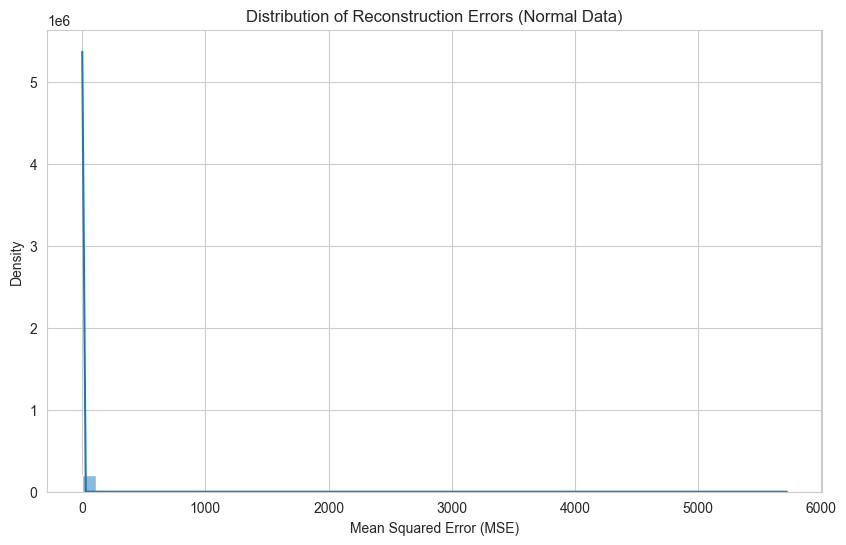

Mean Reconstruction Error: 1.158645
Std Deviation of Error: 17.109220
Anomaly Threshold (Mean + 3*Std): 52.486307


In [ ]:

# AUTOENCODER: STEP 4 (Find Threshold) 

# ------------------------------------------------- #

from sklearn.metrics import mean_squared_error

print("--- Calculating Reconstruction Errors on Normal Data ---")


# 1. Get the autoencoder's predictions for the *normal* training data

reconstructions = autoencoder.predict(X_train_normal)

# ------------------------------------------------- #

# 2. Calculate the Mean Squared Error (MSE) for each transaction

# This is our "reconstruction error"

mse = np.mean(np.power(X_train_normal - reconstructions, 2), axis=1)

# ------------------------------------------------- #

# 3. Plot the distribution of these errors

plt.figure(figsize=(10, 6))
sns.histplot(mse, bins=50, kde=True)
plt.title('Distribution of Reconstruction Errors (Normal Data)')
plt.xlabel('Mean Squared Error (MSE)')
plt.ylabel('Density')
plt.show()

# ------------------------------------------------- #

# 4. Define the anomaly threshold

# A common way is to use the mean + 3 standard deviations
# This captures ~99.7% of the "normal" data

mean_error = mse.mean()
std_error = mse.std()
threshold = mean_error + (3 * std_error)

print(f"Mean Reconstruction Error: {mean_error:.6f}")
print(f"Std Deviation of Error: {std_error:.6f}")
print(f"Anomaly Threshold (Mean + 3*Std): {threshold:.6f}")

# ------------------------------------------------- #


--- Evaluating Autoencoder on the UNBALANCED Test Set ---
2671/2671 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step

--- Autoencoder Results (Threshold = 52.486307) ---
              precision    recall  f1-score   support

No Fraud (0)       1.00      1.00      1.00     85295
   Fraud (1)       0.19      0.21      0.20       148

    accuracy                           1.00     85443
   macro avg       0.59      0.60      0.60     85443
weighted avg       1.00      1.00      1.00     85443

Plotting Confusion Matrix...


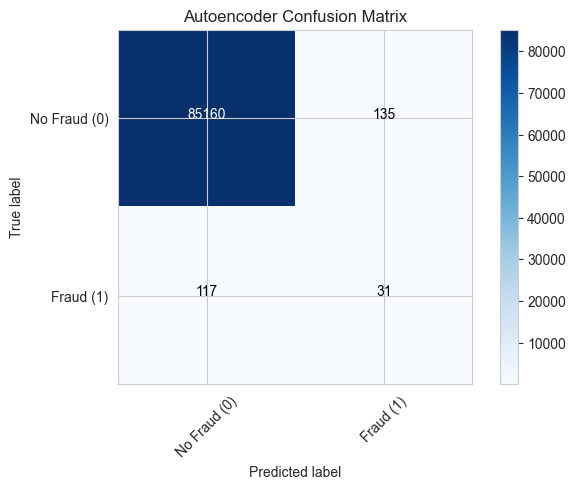

In [ ]:

# AUTOENCODER : STEP 5 (Evaluate on Test Set)

# ------------------------------------------------- #

print("\n--- Evaluating Autoencoder on the UNBALANCED Test Set ---")

# We already have our threshold
threshold = 52.486307


# 1. Get reconstructions for the full, imbalanced X_test

test_reconstructions = autoencoder.predict(X_test)

# ------------------------------------------------- #

# 2. Calculate the reconstruction error for each test transaction

test_mse = np.mean(np.power(X_test - test_reconstructions, 2), axis=1)

# ------------------------------------------------- #

# 3. Classify as fraud or not based on our threshold

# If test_mse > threshold, predict 1 (Fraud), else 0 (No Fraud)

y_pred_autoencoder = (test_mse > threshold).astype(int)

# ------------------------------------------------- #

# 4. Print the Classification Report

# We can finally see the Precision and Recall!

print(f"\n--- Autoencoder Results (Threshold = {threshold:.6f}) ---")
print(classification_report(y_test, y_pred_autoencoder, target_names=['No Fraud (0)', 'Fraud (1)']))

# ------------------------------------------------- #

# 5. Plot the Confusion Matrix

# We can re-use our 'plot_confusion_matrix' function from Step 6

print("Plotting Confusion Matrix...")
cm_autoencoder = confusion_matrix(y_test, y_pred_autoencoder)
plot_confusion_matrix(cm_autoencoder, classes=['No Fraud (0)', 'Fraud (1)'], title='Autoencoder Confusion Matrix')

# ------------------------------------------------- #

API ADD-ON

In [ ]:

# API ADD-ON: STEP 1 (Save Model)

# ------------------------------------------------- #

import joblib

# The 'final_model' from Step 8 is our definitive, clean, bug-free model.
# This is the one we will use for our API.
model_to_save = final_model

# Save the model to a file
joblib.dump(model_to_save, 'fraud_model.joblib')

print(f"--- Model '{model_to_save.__class__.__name__}' saved to 'fraud_model.joblib' ---")
print("This is the file you will load in your 'main.py' for the API.")

--- Model 'XGBClassifier' saved to 'fraud_model.joblib' ---
This is the file you will load in your 'main.py' for the API.


In [ ]:

# API ADD-ON: STEP 2 (Test API) 

# ------------------------------------------------- #

import requests
import json

# We need to install the 'requests' library
!pip install requests


# 1. Get a "Normal" transaction from our X_test set 

# We'll grab a row our model has never seen
normal_transaction = X_test.iloc[0].to_dict()

# ------------------------------------------------- #

# 2. Send it to our API

print("--- Sending a NORMAL transaction to our API... ---")
url = "http://127.0.0.1:8000/predict"
response = requests.post(url, json=normal_transaction)
print(f"Response: {response.json()}\n")

# ------------------------------------------------- #

# 3. Get a "Fraud" transaction from our X_test set 

# We find a real fraud case to test
fraud_transaction = X_test[y_test == 1].iloc[0].to_dict()

# ------------------------------------------------- #

# 4. Send it to our API

print("--- Sending a FRAUD transaction to our API... ---")
response = requests.post(url, json=fraud_transaction)
print(f"Response: {response.json()}")

# ------------------------------------------------- #

--- Sending a NORMAL transaction to our API... ---
Response: {'prediction': 0, 'status': 'Transaction Approved', 'fraud_probability': 0.0}

--- Sending a FRAUD transaction to our API... ---
Response: {'prediction': 1, 'status': 'Transaction BLOCKED (Fraud Detected)', 'fraud_probability': 1.0}



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip
C:\Users\Jyothir Aditya\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\utils\_process_win32.py:124: ResourceWarning: unclosed file <_io.BufferedWriter name=5>
  return process_handler(cmd, _system_body)
C:\Users\Jyothir Aditya\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\utils\_process_win32.py:124: ResourceWarning: unclosed file <_io.BufferedReader name=7>
  return process_handler(cmd, _system_body)
C:\Users\Jyothir Aditya\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\utils\_process_win32.py:124: ResourceWarning: unclosed file <_io.BufferedReader name=8>
  return process_handler(cmd, _system_body)


In [34]:
print(X_test.columns)

Index(['V1', 'V2', 'V3', 'V4', 'V5', '`', 'S', 'V8', 'V9', 'V10', 'V11', 'V12',
       'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22',
       'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'scaled_amount',
       'scaled_time'],
      dtype='object')


In [35]:
print(X_train.columns)

Index(['V1', 'V2', 'V3', 'V4', 'V5', '`', 'S', 'V8', 'V9', 'V10', 'V11', 'V12',
       'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22',
       'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'scaled_amount',
       'scaled_time'],
      dtype='object')


In [ ]:
# FIX X_test COLUMNS FOR API TEST

# ------------------------------------------------- #

# DefinING the correct column names
correct_columns = [f'V{i}' for i in range(1, 29)] + ['scaled_amount', 'scaled_time']

print("Original X_test columns:", X_test.columns.tolist())

# Assign the correct names JUST to X_test
X_test.columns = correct_columns

print("\n--- Columns corrected for X_test ---")
print("New X_test columns:", X_test.columns.tolist())

Original X_test columns: ['V1', 'V2', 'V3', 'V4', 'V5', '`', 'S', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'scaled_amount', 'scaled_time']

--- Columns corrected for X_test ---
New X_test columns: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'scaled_amount', 'scaled_time']


In [ ]:

# API ADD-ON: STEP 2 (Test API - Re-run) 

# ------------------------------------------------- #

import requests
import json

# 1. Get a "Normal" transaction (Columns are now fixed) 

normal_transaction = X_test.iloc[0].to_dict()

# ------------------------------------------------- #

# 2. Send it to our API 

print("--- Sending a NORMAL transaction to our API... ---")
url = "http://127.0.0.1:8000/predict"
response = requests.post(url, json=normal_transaction)
print(f"Response: {response.json()}\n")

# ------------------------------------------------- #

# --- 3. Get a "Fraud" transaction (Columns are now fixed)

fraud_transaction = X_test[y_test == 1].iloc[0].to_dict()

# ------------------------------------------------- #

# 4. Send it to our API

print("--- Sending a FRAUD transaction to our API... ---")
response = requests.post(url, json=fraud_transaction)
print(f"Response: {response.json()}")

--- Sending a NORMAL transaction to our API... ---
Response: {'prediction': 0, 'status': 'Transaction Approved', 'fraud_probability': 0.0}

--- Sending a FRAUD transaction to our API... ---
Response: {'prediction': 1, 'status': 'Transaction BLOCKED (Fraud Detected)', 'fraud_probability': 1.0}
